In [1]:
import os as os
import numpy as np
import scipy.stats as st
import cvxpy as cvx
import pandas as pd
import datetime
import warnings
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
warnings.filterwarnings('ignore')

In [2]:
# 二回目の銘柄数
constCnt = 40

portName = 'portfolio'+str(constCnt)


#過去指数ファンド情報読み取り
tickers=pd.read_csv('sp500_alive.csv')
tickers=tickers['ticker'].to_list()     #ticker列のデータ取得

#一件目のファンドの過去日付データ読み取り
data = pd.read_csv('./data/'+tickers[0]+'.csv')
data = data.drop(['Open', 'High','Low','Close','Adj Close','Volume'], axis=1)

dataDate = data.copy()

In [3]:
#過去期間2013-01-02～2018-12-31のファンドの過去データ取得
for ticker in tickers:
    d = pd.read_csv('./data/'+ticker+'.csv')
    d = d.drop(['Open', 'High','Low','Adj Close','Volume'], axis=1)
    d = d.rename(columns={'Close': ticker}) #列名称をファンド名にリネーム
    
    date1 = d.iat[0,0]
    if date1 == "2012-12-31":
        data = pd.merge(data,d,on='Date')



In [5]:
data=data[data['Date'] != "2012-12-31"]
data.reset_index(inplace=True, drop=True)

In [6]:
data.head()

,Date,AAPL,MSFT,AMZN,NVDA,GOOGL,GOOG,META,UNH,TSLA,...,DVA,ALK,DXC,MHK,RL,CMA,ZION,NWL,LNC,DISH
0,2013-01-02,19.608213,27.620001,12.8655,3.1800,18.099348,18.013729,28.000000,54.540001,2.357333,...,54.599998,21.969999,20.617765,93.169998,152.100006,31.320000,21.990000,22.610001,27.410000,36.959999
1,2013-01-03,19.360714,27.250000,12.9240,3.1825,18.109859,18.024191,27.770000,51.990002,2.318000,...,54.965000,22.379999,20.652542,93.269997,157.210007,31.719999,22.020000,22.459999,27.900000,36.930000
2,2013-01-04,18.821428,26.740000,12.9575,3.2875,18.467718,18.380356,28.760000,52.090000,2.293333,...,54.919998,22.690001,20.697256,93.519997,159.389999,32.590000,22.650000,22.549999,28.110001,36.889999
3,2013-01-07,18.710714,26.690001,13.4230,3.1925,18.387136,18.300158,29.420000,52.090000,2.289333,...,54.145000,23.174999,20.478659,92.739998,161.520004,32.340000,22.540001,22.139999,27.799999,36.340000
4,2013-01-08,18.761070,26.549999,13.3190,3.1225,18.350851,18.264042,29.059999,51.400002,2.245333,...,54.834999,23.000000,20.061335,93.300003,162.250000,31.930000,22.090000,22.209999,27.370001,35.970001


In [7]:
#日付、年、月、週というデータを取得する
cal = data[['Date']]
cal['Datetime'] = pd.to_datetime(cal['Date'])
cal['year'] = cal['Datetime'].dt.year
cal['month'] = cal['Datetime'].dt.month
cal['week'] = cal['Datetime'].dt.week

cal['mon'] = 1
for index, row in cal.iterrows():
    if index > 0 and cal.iloc[index,3] != cal.iloc[index-1,3]:
        cal.iloc[index,5] = cal.iloc[index-1,5]+1
    else:
        cal.iloc[index,5] = cal.iloc[index-1,5]
        
cal['iweek'] = 1
for index, row in cal.iterrows():
    if index > 0 and cal.iloc[index,4] != cal.iloc[index-1,4]:
        cal.iloc[index,6] = cal.iloc[index-1,6]+1
    else:
        cal.iloc[index,6] = cal.iloc[index-1,6]

In [8]:
#インデックス設定
data = data.set_index('Date')

# 行・列の差分・変化率を取得する
R = data.pct_change()
R = R.fillna(0)

#累積しないリターンを保存
Rd = R
R = R + 1

#累積リータン
R = R.cumprod()

#配列T：縦、N：横
T = Rd.shape[0]
N = Rd.shape[1]

#ベンチマーク情報
Benchmark = pd.read_csv('sp500.csv')
Benchmark = Benchmark.set_index('Date')
Benchmark = Benchmark.drop(['Open', 'High','Low','Adj Close','Volume'], axis=1)

In [9]:
#------------------------------------------------
#シミュレーション
#------------------------------------------------
di = Benchmark.copy() # ポートフォリオの時価総額の推移
Benchmarkd = Benchmark.copy()
Benchmarkd = Benchmarkd.pct_change()
Benchmarkd = Benchmarkd.fillna(0)

did = Benchmark.copy() #日次
did100 = Benchmark.copy() #日次


#最適ウェイト計算の
mon_window = 48 # 6年間72月


w_init = np.ones(N)/N
w_initd = np.ones(N)/N
# w_initm = np.ones(N)/N

N100=constCnt
w_init100 = np.ones(N100)/N100
w_initd100 = np.ones(N100)/N100



for i in range(120 - mon_window):
    start = 1
    end = i+mon_window
    
    # 計算対象の開始終了
    startdate = cal.query('mon >= '+str(start)+' and mon <= '+str(end))['Date'].min()
    enddate = cal.query('mon >= '+str(start)+' and mon <= '+str(end))['Date'].max()

    # 日次リターンで最適化
    # 各資産の計算期間分のデータを取得し計算期間初からのリターンを計算
    assetd = Rd[startdate:enddate]
    assetd = assetd.values
    
    # ベンチマークの計算期間分のデータを取得し計算期間初からのリターンを計算
    indxd = Benchmarkd[startdate:enddate]
    indxd = indxd.values
    indxd = np.squeeze(indxd)

    # 最適化ソルバでウェイトを算出
    weightd = cvx.Variable(N,value=w_initd)
    objd = cvx.Minimize(cvx.sum_squares((assetd@weightd) - indxd))
    mintracerrd = cvx.Problem(objd, [cvx.sum(weightd) == 1.0,weightd >= 0])
    mintracerrd.solve(verbose=False)
    wd = weightd.value
    
    wd[wd<0]=0
    wd=wd/wd.sum()
    w_initd = wd
    
    #--------------------------------------------------------------------
    # ウェイト上位100のファンドを判断し、再最適化ツルバでウェイトを算出
    wdSorted = sorted(wd, reverse=True)
    max100 = []
    for j in range(constCnt):
        weightValue = wdSorted[j]
        max100 = max100 + [m for m, v in enumerate(wd) if v == weightValue]
            
    tickers100 = []
    tickersList = R.columns
    for n in range(constCnt):
        indexN = max100[n]
        tickers100.append(tickersList[indexN])
    
    print(tickers100)
    
    Rd100 = Rd.copy()
    R100 = R.copy()
    for m in range(len(tickersList)):
        colName = tickersList[m]
        n = 0
        for j in range(constCnt):
            if colName == tickers100[j]:
                n = 1
        if(n==0):   
            Rd100 = Rd100.drop(colName,axis=1)
            R100 = R100.drop(colName,axis=1)

    assetd100 = Rd100[startdate:enddate]    
    assetd100 = assetd100.values
    
    weightd100 = cvx.Variable(N100,value=w_initd100)
    objd100 = cvx.Minimize(cvx.sum_squares((assetd100@weightd100) - indxd))
    mintracerrd100 = cvx.Problem(objd100, [cvx.sum(weightd100) == 1.0,weightd100 >= 0])
    mintracerrd100.solve(verbose=False)
    wd100 = weightd100.value
    
    wd100[wd100<0]=0
    wd100=wd100/wd100.sum()
    w_initd100 = wd100
    
    #----------------------------------------------------------------------
    
    # 計算したウェイトと運用期間の各資産のリターンから運用期間のポートフォリオの時価評価額の比率を計算
    dstart = cal.query('mon >= '+str(end+1)+' and mon <= '+str(end+1))['Date'].min()
    dend = cal.query('mon >= '+str(end+1)+' and mon <= '+str(end+1))['Date'].max()
    dstartm1 = cal.query('mon >= '+str(end)+' and mon <= '+str(end))['Date'].max()

    #Backtest期間
    rtmpd=R[dstartm1:dend]
        
    rtmpd = rtmpd.pct_change()
    rtmpd = rtmpd.dropna()
    rtmpd = rtmpd + 1
    rtmpd = rtmpd.cumprod()

    dd = rtmpd.values@wd
    dd = dd*did.at[dstartm1,'Close']

    dd = np.expand_dims(dd, 1)
    did[dstart:dend]=dd
    
    #--------------------------------------------------------------------
    rtmpd100=R100[dstartm1:dend]
    rtmpd100 = rtmpd100.pct_change()
    rtmpd100 = rtmpd100.dropna()
    rtmpd100 = rtmpd100 + 1
    rtmpd100 = rtmpd100.cumprod()
    dd100 = rtmpd100.values@wd100
    dd100 = dd100*did100.at[dstartm1,'Close']
    dd100 = np.expand_dims(dd100, 1)
    did100[dstart:dend]=dd100
    #----------------------------------------------------------------------

['AAPL', 'XOM', 'MSFT', 'WFC', 'JNJ', 'GE', 'PFE', 'JPM', 'GOOGL', 'KO', 'T', 'CVX', 'DIS', 'IBM', 'BAC', 'INTC', 'UNH', 'PM', 'CMCSA', 'MDT', 'SLB', 'MRK', 'AMZN', 'PG', 'AMGN', 'BMY', 'MO', 'GILD', 'HD', 'CSCO', 'GOOG', 'VZ', 'C', 'ORCL', 'QCOM', 'AXP', 'MMM', 'WMT', 'AIG', 'PEP']
['AAPL', 'XOM', 'MSFT', 'WFC', 'JNJ', 'PFE', 'GE', 'JPM', 'T', 'KO', 'CVX', 'GOOGL', 'IBM', 'DIS', 'BAC', 'INTC', 'CMCSA', 'UNH', 'PM', 'MDT', 'AMZN', 'MRK', 'PG', 'SLB', 'AMGN', 'MO', 'BMY', 'GILD', 'HD', 'GOOG', 'CSCO', 'ORCL', 'PEP', 'GS', 'MMM', 'WMT', 'AXP', 'C', 'MA', 'AIG']
['AAPL', 'XOM', 'MSFT', 'WFC', 'JNJ', 'GE', 'PFE', 'JPM', 'CVX', 'KO', 'T', 'IBM', 'DIS', 'GOOGL', 'BAC', 'INTC', 'CMCSA', 'UNH', 'PM', 'MDT', 'AMZN', 'MRK', 'PG', 'GOOG', 'SLB', 'AMGN', 'MO', 'HD', 'BMY', 'GILD', 'CSCO', 'GS', 'PEP', 'MMM', 'ORCL', 'C', 'WMT', 'AXP', 'AIG', 'VZ']
['AAPL', 'XOM', 'MSFT', 'WFC', 'JNJ', 'GE', 'JPM', 'PFE', 'T', 'KO', 'GOOGL', 'CVX', 'IBM', 'DIS', 'BAC', 'PM', 'CMCSA', 'INTC', 'PG', 'UNH', 'AMZN', 'M

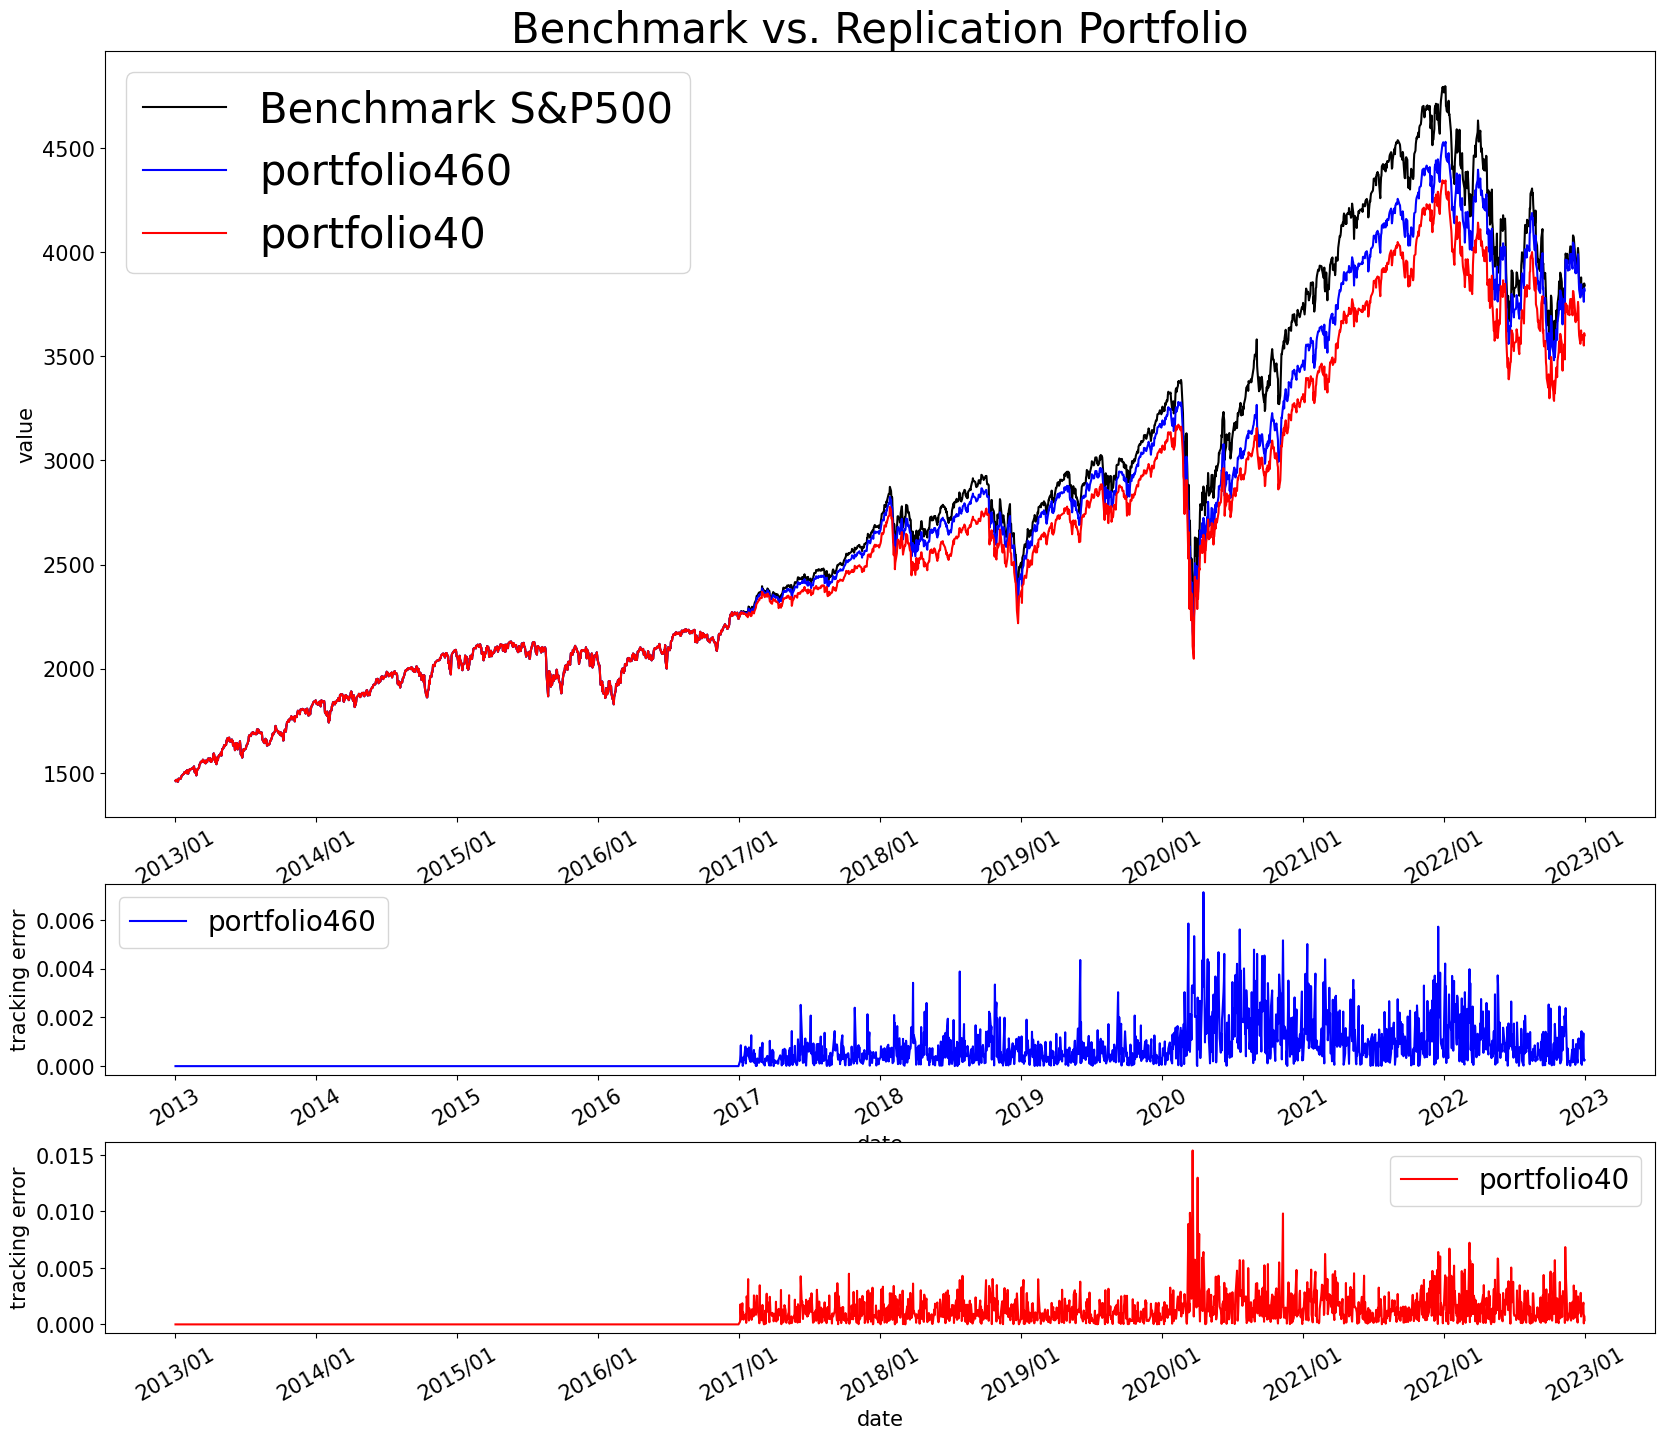

In [10]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
ganpon=100000
fig = make_subplots(rows=2, cols=1)


Benchmark.to_csv('b2.csv')
di.to_csv('d2.csv')

from matplotlib import dates as mdates

heights = [4, 1,1,1]
fig = plt.figure(figsize=(20, 20))
spec = fig.add_gridspec(ncols=1, nrows=4,  height_ratios=heights)
#spec = fig.add_gridspec(ncols=1, nrows=5)
ax = fig.add_subplot(spec[0, 0])

#ベンチマーク
ax.plot(pd.to_datetime(Benchmark.index),Benchmark['Close'],c='k')
#フル460銘柄
ax.plot(pd.to_datetime(did.index),did['Close'],c='b',linestyle="-")
#一部銘柄
ax.plot(pd.to_datetime(did100.index),did100['Close'],c='r',linestyle="-")


# ax.legend(labels=['Benchmark S&P500','portfolio460',portName,'portfolio100日次R','portfolio月次R'],fontsize=30)

ax.legend(labels=['Benchmark S&P500','portfolio460',portName],fontsize=30)
ax.set_xlabel('date', size=15)
ax.set_ylabel('value', size=15)
ax.set_title('Benchmark vs. Replication Portfolio', fontsize=30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation=30)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m'))

#
#TE計算
#

portDaily = did.pct_change()
portDaily = portDaily.fillna(0)

portDaily100 = did100.pct_change()
portDaily100 = portDaily100.fillna(0)

ax = fig.add_subplot(spec[1, 0])
ax.plot(pd.to_datetime(Benchmark.index),((Benchmarkd['Close']-portDaily['Close'])**2)**0.5, c='b')
ax.legend(labels=['portfolio460'],fontsize=20)

ax.set_xlabel('date', size=15)
ax.set_ylabel('tracking error', size=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation=30)

ax = fig.add_subplot(spec[2, 0])
ax.plot(pd.to_datetime(Benchmark.index),((Benchmarkd['Close']-portDaily100['Close'])**2)**0.5, c='r')
ax.legend(labels=[portName],fontsize=20)

ax.set_xlabel('date', size=15)
ax.set_ylabel('tracking error', size=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation=30)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m'))

fig.savefig(portName+'.png')

In [11]:
did100.to_csv(portName+'.csv')

In [12]:
te=((Benchmarkd['Close']-portDaily100['Close'])**2)**0.5
te = te['2017-01-01':]
print(te.median())

0.0010786594359574742
